# 中文新闻分类：Word2Vec
本实验使用中文数据集，结合 Word2Vec 词向量和传统机器学习方法，对新闻文本进行真假分类。
Python版本：3.11.8

In [ ]:

import os
import multiprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm
import jieba

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns


## 1. 加载数据
数据集为excel文件，分为2列。第一列是新闻文本，第二列是一个数字，其中0表示真新闻，1表示假新闻

In [ ]:

# 设置数据路径
TRAIN_PATH = 'D:/Users/CN096/NLP/word2vec/train_data.csv'
TEST_PATH = 'D:/Users/CN096/NLP/word2vec/test_data.csv'
STOPWORDS_PATH = 'D:/Users/CN096/NLP/word2vec/stopwords.txt'

# 加载训练集和测试集（Excel 格式）
train_df = pd.read_excel(TRAIN_PATH)
test_df = pd.read_excel(TEST_PATH)

print("训练样本数:", len(train_df), "测试样本数:", len(test_df))
labels = sorted(train_df['label'].unique())  # 可能的标签值


训练样本数: 8469 测试样本数: 2118

## 2. 加载停用词表

In [ ]:

# 加载停用词
with open(STOPWORDS_PATH, 'r', encoding='utf-8') as f:
    stop_words = set(line.strip() for line in f)


## 3. 文本清洗与分词

In [ ]:

# 定义清洗 + 分词函数（使用 jieba）
def clean_text(text):
    tokens = jieba.lcut(str(text))
    tokens = [w for w in tokens if w.strip() and w not in stop_words]
    return tokens

tqdm.pandas()
train_df['tokens'] = train_df['text'].progress_apply(clean_text)
test_df['tokens'] = test_df['text'].progress_apply(clean_text)


## 4. 训练 Word2Vec 词向量模型
分别训练100维、300维的词向量以对比效果

In [ ]:

# 训练 Word2Vec（100维、300维）
sentences = train_df['tokens'].tolist()
EMBEDDINGS = {}

for dim in [100, 300]:
    print(f"Training Word2Vec {dim}-dim...")
    w2v = Word2Vec(sentences=sentences,
                   vector_size=dim,
                   window=5,
                   min_count=2,
                   workers=multiprocessing.cpu_count(),
                   epochs=10)
    EMBEDDINGS[dim] = w2v


## 5. 文本向量化函数（平均向量和 TF-IDF 加权平均）

In [ ]:

def doc_vector_mean(tokens, model):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

def doc_vector_tfidf(tokens, model, tfidf_dict):
    vecs = []
    weights = []
    for w in tokens:
        if w in model.wv and w in tfidf_dict:
            vecs.append(model.wv[w] * tfidf_dict[w])
            weights.append(tfidf_dict[w])
    if not vecs:
        return np.zeros(model.vector_size)
    return np.sum(vecs, axis=0) / np.sum(weights)


## 6. 构建 TF-IDF 字典

In [ ]:

tfidf = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None, min_df=2)
tfidf_matrix = tfidf.fit_transform(train_df['tokens'])
idf_scores = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))


## 7. 构建特征向量

In [ ]:

def build_features(df, model, method='mean'):
    vectors = []
    for tokens in df['tokens']:
        if method == 'mean':
            vectors.append(doc_vector_mean(tokens, model))
        elif method == 'tfidf':
            vectors.append(doc_vector_tfidf(tokens, model, idf_scores))
    return np.vstack(vectors)


## 8. 训练分类器并评估
评估多种分类器（SVM、逻辑回归、随机森林）在文本表示下的效果

In [ ]:

results = []
classifiers = {
    'SVM': LinearSVC(),
    'LogReg': LogisticRegression(max_iter=1000),
    'RF': RandomForestClassifier(n_estimators=200, random_state=42)
}

for dim, model in EMBEDDINGS.items():
    for method in ['mean', 'tfidf']:
        print(f"Processing features: {dim}d-{method}")
        X_train = build_features(train_df, model, method)
        y_train = train_df['label']
        X_test = build_features(test_df, model, method)
        y_test = test_df['label']

        for clf_name, clf in classifiers.items():
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            results.append({'dim': dim, 'method': method, 'clf': clf_name, 'acc': acc, 'f1': f1})
            print(f"{dim}d-{method}-{clf_name} | Acc: {acc:.4f} | F1: {f1:.4f}")


## 9. 总结结果
实验结果如下表所示

In [ ]:

results_df = pd.DataFrame(results).sort_values(by='f1', ascending=False)
print(results_df)

best = results_df.iloc[0]
print("Best setting:", best.to_dict())


| Rank | 维度 | 表示方法 | 分类器 | 准确率 (Acc) | F1 分数 |
|------|------|----------|--------|--------------|---------|
| 1    | 300  | tfidf    | RF     | **0.9485**   | **0.9479** |
| 2    | 100  | mean     | RF     | 0.9448       | 0.9443 |
| 3    | 300  | mean     | RF     | 0.9443       | 0.9437 |
| 4    | 100  | tfidf    | RF     | 0.9438       | 0.9431 |
| 5    | 300  | tfidf    | SVM    | 0.8905       | 0.8860 |
| 6    | 300  | tfidf    | LogReg | 0.8890       | 0.8853 |
| 7    | 100  | tfidf    | LogReg | 0.8890       | 0.8849 |
| 8    | 100  | tfidf    | SVM    | 0.8890       | 0.8842 |
| 9    | 100  | mean     | SVM    | 0.8876       | 0.8828 |
| 10   | 100  | mean     | LogReg | 0.8857       | 0.8815 |
| 11   | 300  | mean     | LogReg | 0.8857       | 0.8813 |
| 12   | 300  | mean     | SVM    | 0.8853       | 0.8800 |

## 10. 混淆矩阵可视化

In [ ]:

best_model = EMBEDDINGS[best['dim']]
X_train_b = build_features(train_df, best_model, best['method'])
X_test_b = build_features(test_df, best_model, best['method'])
y_train_b = train_df['label']
y_test_b = test_df['label']

clf = classifiers[best['clf']]
clf.fit(X_train_b, y_train_b)
y_pred_b = clf.predict(X_test_b)

cm = confusion_matrix(y_test_b, y_pred_b, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


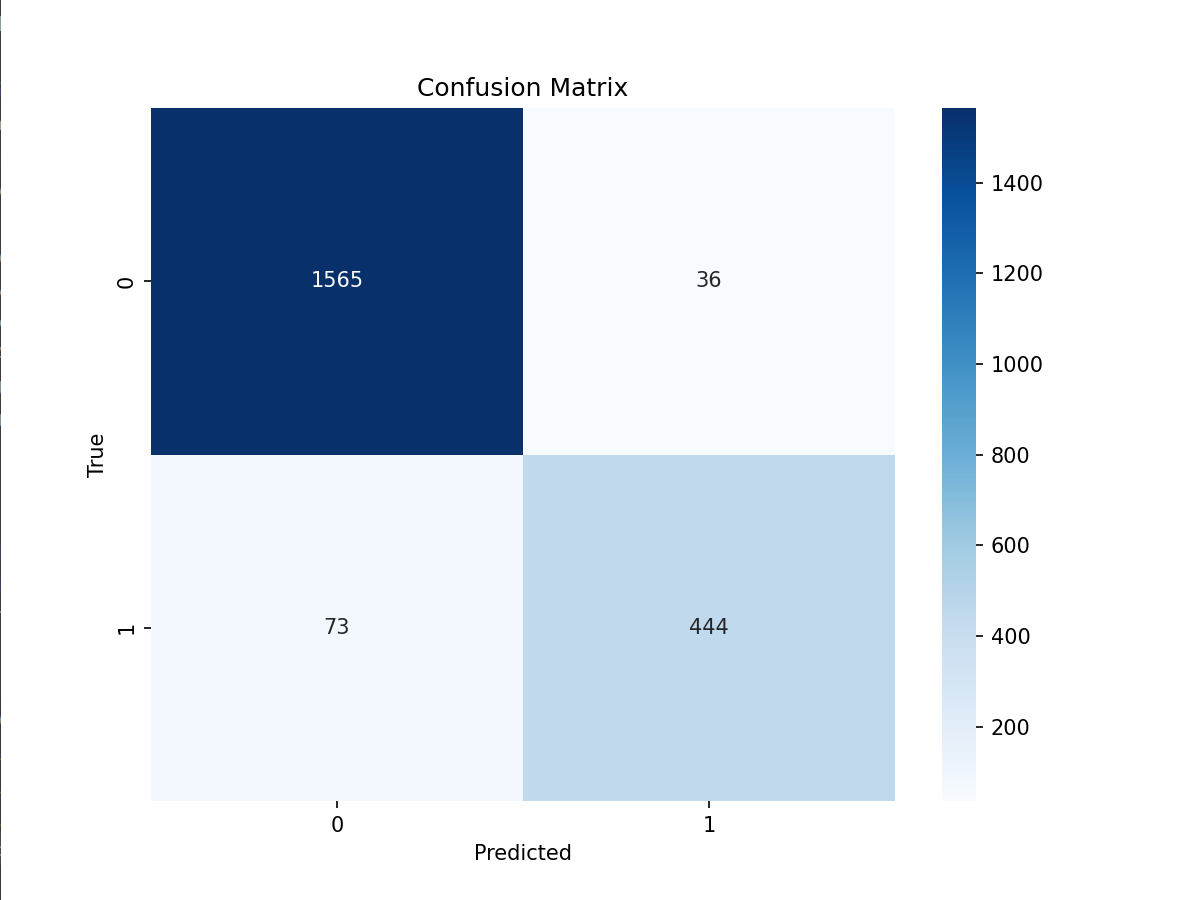